In [0]:
train = "https://raw.githubusercontent.com/rani700/corona/master/datasets/train.csv"
test = "https://raw.githubusercontent.com/rani700/corona/master/datasets/test.csv"

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [0]:
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

In [0]:
df_train = df_train.rename(columns={'Country/Region': 'Country', 'Province/State': 'State'})
df_test = df_test.rename(columns={'Country/Region': 'Country', 'Province/State': 'State'})

In [0]:
df_new = df_train.iloc[:, [2, 5, 6, 7]].groupby(['Country', 'Date']).sum()

In [0]:
def plotGraph(country_name):
  df_country = df_new.iloc[df_new.index.get_level_values('Country') == country_name]
  df_country.index = df_country.index.droplevel(0)
  df_country.plot(figsize=(10, 8), title=country_name)  

In [0]:
def getData(country_name, N_min = 10, N_max = 15, O = 5, P_min = 10, P_max = 15):
  df_country = df_new.iloc[df_new.index.get_level_values('Country') == country_name]
  data = df_country.values[:, [0]]

  scaler = StandardScaler()
  scaler.fit(data)
  data = scaler.transform(data)

  # scaler_y = StandardScaler()
  # scaler_y.fit(data[:, [1]])
  # scaler_y.transform(data[:, [1]])

  N_min = N_min
  N_max = N_max
  O = O
  P_min = P_min
  P_max = P_max
  Dimension = 1

  X = []
  y = []

  for N in range(N_min, N_max+1):
    for P in range(P_min, P_max+1):
      for i in range(len(data) - (N + O + P) +1):
        N_pad = N_max - N
        P_pad = P_max - P

        temp1 = data[i : i+N]
        temp2 = [[0 for __ in range(Dimension)] for _ in range(N_pad)]
        temp3 = [[0 for __ in range(Dimension)] for _ in range(O)]
        temp4 = data[i+N+O : i+N+O+P]
        temp5 = [[0 for __ in range(Dimension)] for _ in range(P_pad)]

        tosave = np.append(np.append(np.append(np.append(temp1, temp2), temp3), temp4), temp5)
        X.append(tosave)
        y.append(data[i+N : i+N+O, 0])
  
  X = np.array(X)
  y = np.array(y)
  X = X.reshape(X.shape[0], Dimension, N_max+O+P_max)

  return X, y, scaler

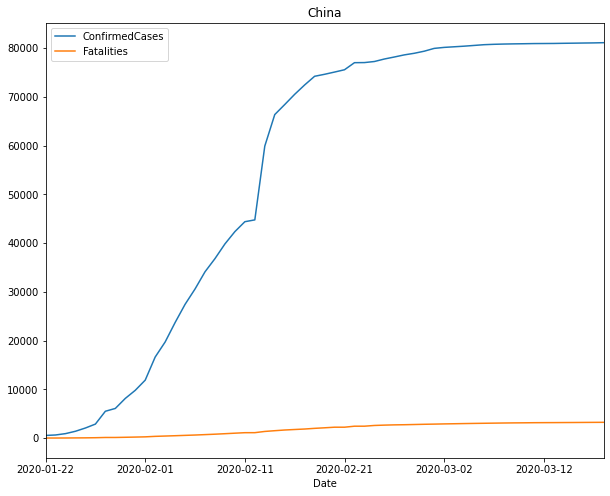

In [33]:
plotGraph('China')

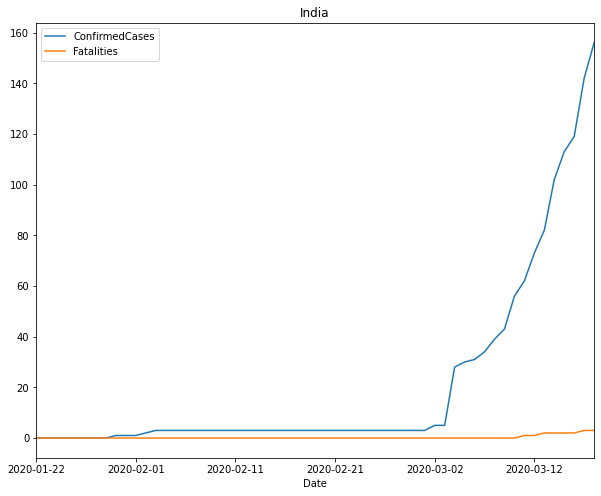

In [34]:
plotGraph('India')

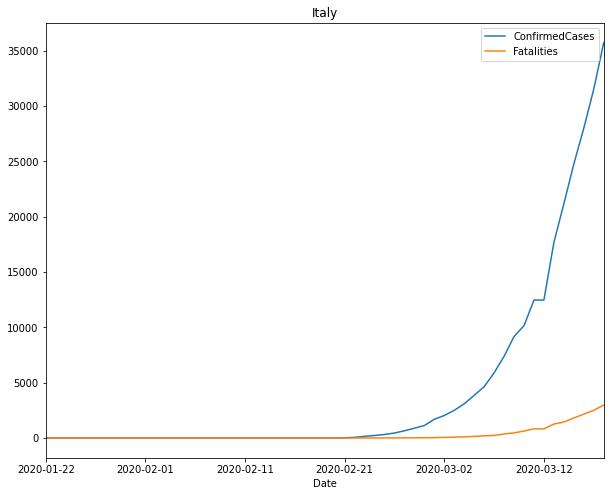

In [35]:
plotGraph('Italy')

In [0]:
Output = 5
X_china, y_china, scaler_china= getData('China', O=Output)

In [37]:
y_china.shape

(1008, 5)

In [38]:
X_china.shape

(1008, 1, 35)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_china_train, X_china_test, y_china_train, y_china_test = train_test_split(X_china, y_china)

In [41]:
!pip install keras-self-attention

In [0]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM, Bidirectional
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras_self_attention import SeqSelfAttention
from keras.layers import Dropout

In [0]:
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_china_train.shape[1], X_china_train.shape[2])))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(LSTM(64))
model.add(Dense(Output))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [44]:
model.fit(X_china_train, y_china_train, epochs=20, verbose=1, validation_data=(X_china_test, y_china_test))

Train on 756 samples, validate on 252 samples
Epoch 1/20
756/756 [==============================] - 4s 5ms/step - loss: 0.2226 - acc: 0.7315 - val_loss: 0.0489 - val_acc: 1.0000
Epoch 2/20
756/756 [==============================] - 0s 481us/step - loss: 0.0327 - acc: 0.6574 - val_loss: 0.0235 - val_acc: 0.8690
Epoch 3/20
756/756 [==============================] - 0s 478us/step - loss: 0.0188 - acc: 0.8413 - val_loss: 0.0157 - val_acc: 0.6032
Epoch 4/20
756/756 [==============================] - 0s 490us/step - loss: 0.0151 - acc: 0.8360 - val_loss: 0.0139 - val_acc: 0.9286
Epoch 5/20
756/756 [==============================] - 0s 486us/step - loss: 0.0140 - acc: 0.8968 - val_loss: 0.0128 - val_acc: 0.8968
Epoch 6/20
756/756 [==============================] - 0s 473us/step - loss: 0.0133 - acc: 0.8545 - val_loss: 0.0127 - val_acc: 0.9127
Epoch 7/20
756/756 [==============================] - 0s 480us/step - loss: 0.0123 - acc: 0.8968 - val_loss: 0.0116 - val_acc: 0.8611
Epoch 8/20
756/756

In [0]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']

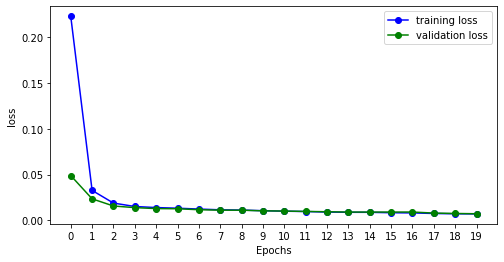

In [46]:
plt.figure(figsize=(8,4))
plt.xticks(np.arange(0,25,1))
plt.plot(range(len(training_loss)),training_loss, 'bo-', label="training loss")
plt.plot(range(len(validation_loss)),validation_loss, 'go-', label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [0]:
y_china_hat = model.predict(X_china_test)

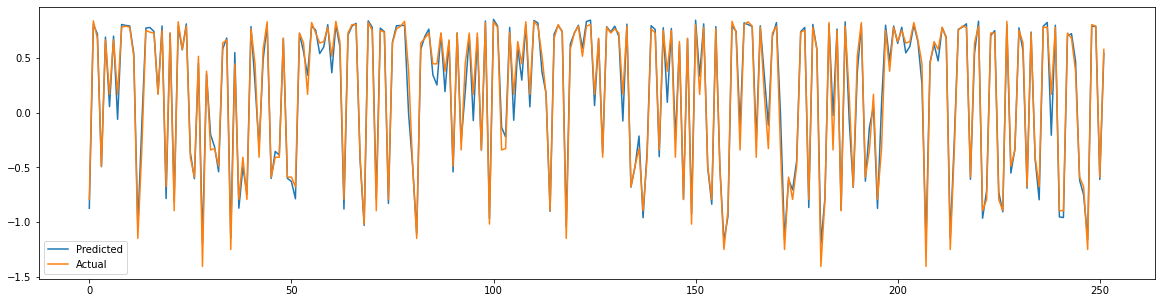

In [48]:
plt.figure(figsize=(20, 5))
plt.plot(y_china_hat[:, 0], label="Predicted")
plt.plot(y_china_test[:, 0], label="Actual")
plt.legend()
plt.show()

In [0]:
def plotComparision(i):
  plt.plot(range(0, 10), scaler_china.inverse_transform(X_china_test[i].reshape(X_china_test.shape[2], X_china_test.shape[1]))[:10, 0], label="Input")
  plt.plot(range(10, 15), scaler_china.inverse_transform(model.predict(np.array([X_china_test[i]]))[0].reshape(-1, 1)), label="Prediction")
  plt.plot(range(10, 15), scaler_china.inverse_transform(y_china_test[i].reshape(-1, 1)), label="Actual")
  plt.legend()
  plt.show()

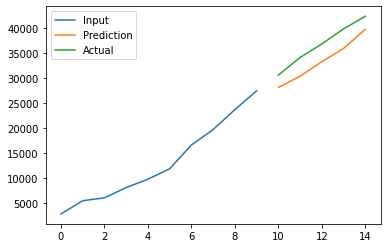

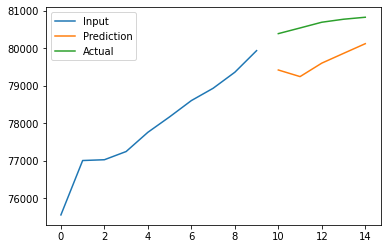

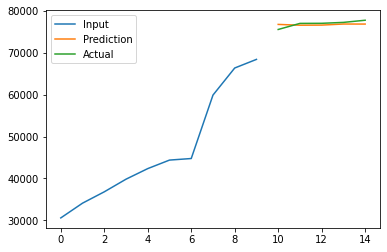

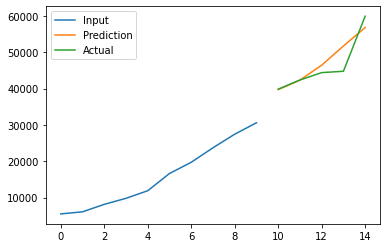

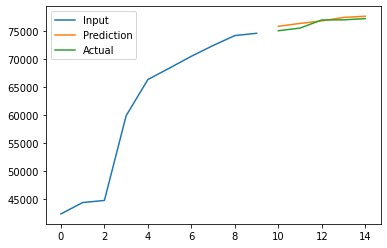

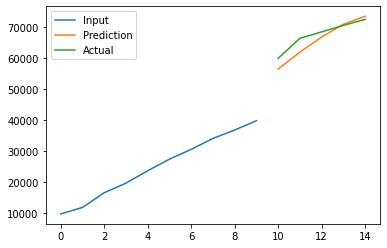

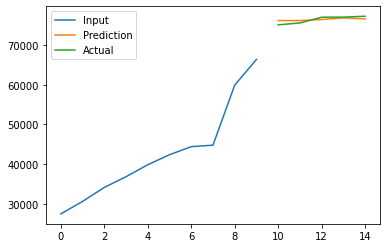

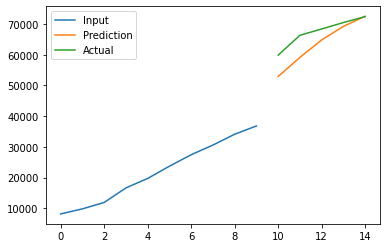

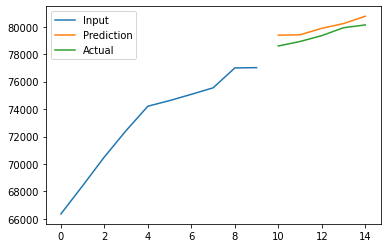

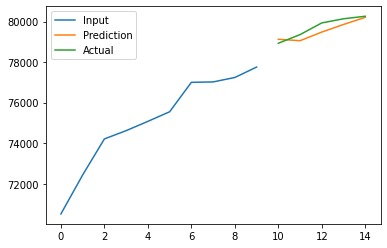

In [50]:
for i in range(10):
  plotComparision(i)